In [103]:
from importlib import reload
from semantic_search import store
reload(store)
from semantic_search.store import LocalEmbeddingModel, FAISSDocumentStore

In [104]:
model = LocalEmbeddingModel(chunk_size=256)
store = FAISSDocumentStore(model, db_dir='/cluster/home/lcarretero/workspace/dsl/dsl-research-assistant/db/references-1')

assert store.load_index()

Loaded index with 21475 vectors


In [105]:
store.search('Test', top_k=5)

[{'rank': 1,
  'score': 0.8346070789658119,
  'document_id': 'W2969289739',
  'chunk_text': 'on the test set.'},
 {'rank': 2,
  'score': 0.8334892017230405,
  'document_id': 'W2019464758',
  'chunk_text': 'is shown to considerably improve performance on the benchmark tests.'},
 {'rank': 3,
  'score': 0.8208612219059436,
  'document_id': 'W3177415989',
  'chunk_text': 'of test - time adaptation of the proposed method.'},
 {'rank': 4,
  'score': 0.7901869436629443,
  'document_id': 'W4321488168',
  'chunk_text': 'research.'},
 {'rank': 5,
  'score': 0.7886736878890741,
  'document_id': 'W4378942443',
  'chunk_text': 'data for testing tasks given a single demonstration as a prompt, which enhances the low - quality datasets for even unseen tasks.'}]

## Benchmarking

In [106]:
import pandas as pd
from typing import List

from importlib import reload
from semantic_search import utils
reload(utils)
from semantic_search.utils import parse_list_string, extract_abstract_from_md

# Set pandas display options to show wider dataframes
pd.set_option('display.max_colwidth', None)  # Show full text in columns
pd.set_option('display.width', 1000)         # Set the display width
pd.set_option('display.max_columns', 20)     # Show more columns

In [107]:
df = pd.read_csv('/cluster/home/lcarretero/workspace/dsl/dsl-research-assistant/raw-data/metadata/openalex-ids+refs.csv')
df['referenced_works'] = df['referenced_works'].apply(parse_list_string)
df['has_refs'] = df.referenced_works.apply(len) > 0
df['abstract'] = df['fpath'].apply(extract_abstract_from_md)
df['has_abstract'] = df.abstract.apply(len) > 0

In [111]:
df = df[df.has_refs & df.has_abstract]  # Only benchmarking on papers with available abstracts and GT references.

max_n_refs = df.GT_refs.apply(len).mean()
print(f'Average number of references per paper: {max_n_refs}')

def predict_refs_from_abstract(abstract: str) -> List[str]:
    docs = store.search(abstract, top_k=max_n_refs)
    return list(set([doc['document_id'] for doc in docs]))

df['predicted_refs'] = df.abstract.apply(predict_refs_from_abstract)
df['GT_refs'] = df.referenced_works.apply(lambda refs: [ref.split('/')[-1] for ref in refs])
df.head(1)

,fpath,title,doi,oaid,referenced_works,has_refs,abstract,has_abstract,predicted_refs,GT_refs
0,/cluster/home/lcarretero/workspace/dsl/dsl-research-assistant/raw-data/Conversions/opencvf-data/txt/Bai_Fixed_Point_Diffusion_Models_CVPR_2024_paper.txt,Fixed Point Diffusion Models,https://doi.org/10.1063/1.2121687,https://openalex.org/W2000456051,"[https://openalex.org/W1504980292, https://openalex.org/W1646044445, https://openalex.org/W1966745391, https://openalex.org/W1976499671, https://openalex.org/W1976755117, https://openalex.org/W1985598807, https://openalex.org/W1990536516, https://openalex.org/W1992279774, https://openalex.org/W1993156367, https://openalex.org/W1993299482, https://openalex.org/W1997562335, https://openalex.org/W1997630751, https://openalex.org/W2002233335, https://openalex.org/W2002497423, https://openalex.org/W2008271164, https://openalex.org/W2012320858, https://openalex.org/W2015794896, https://openalex.org/W2020546548, https://openalex.org/W2024726841, https://openalex.org/W2026423508, https://openalex.org/W2026973935, https://openalex.org/W2030669930, https://openalex.org/W2043668344, https://openalex.org/W2049475242, https://openalex.org/W2053140944, https://openalex.org/W2055341112, https://openalex.org/W2057955560, https://openalex.org/W2058955158, https://openalex.org/W2059351168, https://openalex.org/W2060474962, https://openalex.org/W2068995897, https://openalex.org/W2071323640, https://openalex.org/W2071986884, https://openalex.org/W2074117796, https://openalex.org/W2074882840, https://openalex.org/W2076036860, https://openalex.org/W2077958064, https://openalex.org/W2077964123, https://openalex.org/W2079161771, https://openalex.org/W2081693079, https://openalex.org/W2087080946, https://openalex.org/W2087596773, https://openalex.org/W2089669941, https://openalex.org/W2094106853, https://openalex.org/W2124818424, https://openalex.org/W2130275650, https://openalex.org/W2130291327, https://openalex.org/W2133894222, https://openalex.org/W2139511716, https://openalex.org/W2140642302, https://openalex.org/W2147216739, https://openalex.org/W2147784945, https://openalex.org/W2152977647, https://openalex.org/W2170450135, https://openalex.org/W3102074653]",True,"We introduce the Fixed Point Diffusion Model (FPDM), a novel approach to image generation that integrates the concept of fixed point solving into the framework of diffusionbased generative modeling. Our approach embeds an implicit fixed point solving layer into the denoising network of a diffusion model, transforming the diffusion process into a sequence of closely-related fixed point problems. Combined with a new stochastic training method, this approach significantly reduces model size, reduces memory usage, and accelerates training. Moreover, it enables the development of two new techniques to improve sampling efficiency: reallocating computation across timesteps and reusing fixed point solutions between timesteps. We conduct extensive experiments with state-of-the-art models on ImageNet, FFHQ, CelebA-HQ, and LSUN-Church, demonstrating substantial improvements in performance and efficiency. Compared to the state-of-the-art DiT model [38], FPDM contains 87% fewer parameters, consumes 60% less memory during training, and improves image generation\n\nquality in situations where sampling computation or time is limited. Our code and pretrained models are available at https://lukemelas.github.io/fixed-point-diffusion-models/.",True,"[W4284969944, W4390874074, W4378446358, W4378509482, W4380994005, W4394656839, W4312293341, W4361866093, W4386076532, W4318348481, W4386346346, W3036167779, W4312933868, W4292419533, W4281872541, W4360884927, W4320343052, W4387723644, W4379261331, W4283318490, W4379261329, W3177150392, W4321276804, W3212516020, W4386066462, W4390871671, W4386071831, W4311397562, W3162926177, W4383176261, W4386076273, W4378474401, W4378760015, W3140633421, W4390873054, W3121370741, W4221159371, W4390871856, W4305031802, W4308167501, W42868

In [112]:
# Calculate precision, recall, and F1 scores
def calculate_metrics(gt_refs, pred_refs):
    assert len(gt_refs) > 0
    gt_set = set(gt_refs)
    pred_set = set(pred_refs)
    
    true_positives = len(gt_set.intersection(pred_set))
    
    precision = true_positives / len(pred_set) if len(pred_set) > 0 else 0
    recall = true_positives / len(gt_set)
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    return precision, recall, f1

# Apply the metrics calculation to each row
metrics = df.apply(lambda row: calculate_metrics(row['GT_refs'], row['predicted_refs']), axis=1)
metrics_df = pd.DataFrame(metrics.tolist(), columns=['precision', 'recall', 'f1'])
metrics_df.mean()

precision    0.152311
recall       0.177845
f1           0.159093
dtype: float64

#### Correct for missing abstracts

In [95]:
ref_df = pd.read_csv('/cluster/home/lcarretero/workspace/dsl/dsl-research-assistant/raw-data/metadata/openalex-refs-abstracts.csv')
ref_df.loc[ref_df.abstract.isna(), 'abstract'] = ''
ref_df['has_abstract'] = ref_df.abstract.map(len) > 0
ref_df.head()

,ref_work,abstract,type,has_abstract
0,https://openalex.org/W2194775991,"Deeper neural networks are more difficult to train. We present a residual learning framework to ease the training of networks that are substantially deeper than those used previously. We explicitly reformulate the layers as learning residual functions with reference to the layer inputs, instead of learning unreferenced functions. We provide comprehensive empirical evidence showing that these residual networks are easier to optimize, and can gain accuracy from considerably increased depth. On the ImageNet dataset we evaluate residual nets with a depth of up to 152 layers - 8× deeper than VGG nets [40] but still having lower complexity. An ensemble of these residual nets achieves 3.57% error on the ImageNet test set. This result won the 1st place on the ILSVRC 2015 classification task. We also present analysis on CIFAR-10 with 100 and 1000 layers. The depth of representations is of central importance for many visual recognition tasks. Solely due to our extremely deep representations, we obtain a 28% relative improvement on the COCO object detection dataset. Deep residual nets are foundations of our submissions to ILSVRC & COCO 2015 competitions1, where we also won the 1st places on the tasks of ImageNet detection, ImageNet localization, COCO detection, and COCO segmentation.",article,True
1,https://openalex.org/W2108598243,"The explosion of image data on the Internet has the potential to foster more sophisticated and robust models and algorithms to index, retrieve, organize and interact with images and multimedia data. But exactly how such data can be harnessed and organized remains a critical problem. We introduce here a new database called ""ImageNet"", a large-scale ontology of images built upon the backbone of the WordNet structure. ImageNet aims to populate the majority of the 80,000 synsets of WordNet with an average of 500–1000 clean and full resolution images. This will result in tens of millions of annotated images organized by the semantic hierarchy of WordNet. This paper offers a detailed analysis of ImageNet in its current state: 12 subtrees with 5247 synsets and 3.2 million images in total. We show that ImageNet is much larger in scale and diversity and much more accurate than the current image datasets. Constructing such a large-scale database is a challenging task. We describe the data collection scheme with Amazon Mechanical Turk. Lastly, we illustrate the usefulness of ImageNet through three simple applications in object recognition, image classification and automatic object clustering. We hope that the scale, accuracy, diversity and hierarchical structure of ImageNet can offer unparalleled opportunities to researchers in the computer vision community and beyond.",article,True
2,https://openalex.org/W1976499671,"Classical Monte Carlo simulations have been carried out for liquid water in the NPT ensemble at 25 °C and 1 atm using six of the simpler intermolecular potential functions for the water dimer: Bernal–Fowler (BF), SPC, ST2, TIPS2, TIP3P, and TIP4P. Comparisons are made with experimental thermodynamic and structural data including the recent neutron diffraction results of Thiessen and Narten. The computed densities and potential energies are in reasonable accord with experiment except for the original BF model, which yields an 18% overestimate of the density and poor structural results. The TIPS2 and TIP4P potentials yield oxygen–oxygen partial structure functions in good agreement with the neutron diffraction results. The accord with the experimental OH and HH partial structure functions is poorer; however, the computed results for these functions are similar for all the potential functions. Consequently, the discrepancy may be due to the correction terms needed in processing the neutron data or to an effect uniformly neglected in the computations. Comparisons are also made for self-diffusion coefficients obtained from molecular dyna

In [94]:
# Calculate the ratio of documents with abstracts by document type
(ref_df.groupby('type')['has_abstract'].mean() * 100).astype(int).sort_values(ascending=False)


type
erratum            100
preprint            99
article             86
review              65
letter              61
dissertation        58
report              50
editorial           50
book                46
dataset             45
other               44
paratext            37
reference-entry     33
book-chapter         5
Name: has_abstract, dtype: int64

In [ ]:
ref_df-

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [73]:
(ref_df.abstract.map(len) > 0).sum()/len(ref_df)*100

81.02719687940188

In [77]:
# Calculate how many abstracts are non-empty for each document type
ref_df.groupby('type').apply(lambda x: ( (x.has_abstract).sum()/len(x)*100 ).round()).sort_values(ascending=False)

/scratch/tmp.29203635.lcarretero/ipykernel_3221674/127375003.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ref_df.groupby('type').apply(lambda x: ( (x.has_abstract).sum()/len(x)*100 ).round()).sort_values(ascending=False)


type
article            100.0
book               100.0
book-chapter       100.0
dissertation       100.0
dataset            100.0
editorial          100.0
erratum            100.0
preprint           100.0
letter             100.0
other              100.0
paratext           100.0
report             100.0
reference-entry    100.0
review             100.0
                     0.0
dtype: float64

## Visualize latent space

In [113]:
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import numpy as np

embeddings = store.embeddings[:10000, :]

# Apply SVD to reduce dimensions to 50 (or another appropriate value)
svd = TruncatedSVD(n_components=32, random_state=42)
embeddings_svd = svd.fit_transform(embeddings)

# Then apply t-SNE on the SVD-reduced embeddings
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_svd)

In [51]:
store.document_store.rename(columns={'id': 'doc_id', 'text': 'doc_text'}, inplace=True)
store.chunk_store.rename(columns={'doc_id': 'doc_id', 'text': 'chunk_text'}, inplace=True)
store.document_store.head()

,doc_id,doc_text,type,has_abstract
0,W1504980292,Classical Monte Carlo simulations have been ca...,article,True
1,W1646044445,Views Icon Views Article contents Figures & ta...,article,True
2,W1966745391,ADVERTISEMENT RETURN TO ISSUEPREVArticleNEXTTh...,article,True
3,W1976499671,"In 1995, the International Association for the...",article,True
4,W1976755117,The ability of simple potential functions to r...,article,True


In [52]:
store.chunk_store.head()

,chunk_id,doc_id,chunk_text
0,0,W1504980292,classical monte carlo simulations have been ca...
1,1,W1504980292,structural and thermodynamic descriptions of l...
2,2,W1646044445,views icon views article contents figures & ta...
3,3,W1966745391,advertisement return to issueprevarticlenextth...
4,4,W1966745391,##f citation counts. the altmetric attention s...


In [53]:
# Join the chunk_store and document_store on document_id
joined_df = pd.merge(
    store.chunk_store,
    store.document_store,
    on='doc_id',
    how='left'
)
joined_df

,chunk_id,doc_id,chunk_text,doc_text,type,has_abstract
0,0,W1504980292,classical monte carlo simulations have been ca...,Classical Monte Carlo simulations have been ca...,article,True
1,1,W1504980292,structural and thermodynamic descriptions of l...,Classical Monte Carlo simulations have been ca...,article,True
2,2,W1646044445,views icon views article contents figures & ta...,Views Icon Views Article contents Figures & ta...,article,True
3,3,W1966745391,advertisement return to issueprevarticlenextth...,ADVERTISEMENT RETURN TO ISSUEPREVArticleNEXTTh...,article,True
4,4,W1966745391,##f citation counts. the altmetric attention s...,ADVERTISEMENT RETURN TO ISSUEPREVArticleNEXTTh...,article,True
...,...,...,...,...,...,...
213077,36374,W575576090,this paper discusses concepts of self - organi...,This paper discusses concepts of self-organize...,article,True
213078,36375,W592386890,october 01 2003 why we see what we do : an emp...,October 01 2003 Why We See What We Do: An Empi...,article,True
213079,36376,W592386890,: 1074 – 1076. doi : https : / / doi. org / 10...,October 01 2003 Why We See What We Do: An Empi...,article,True
213080,36377,W617170969,normative theories of learning and decision - ...,Normative theories of learning and decision-ma...,book-chapter,True


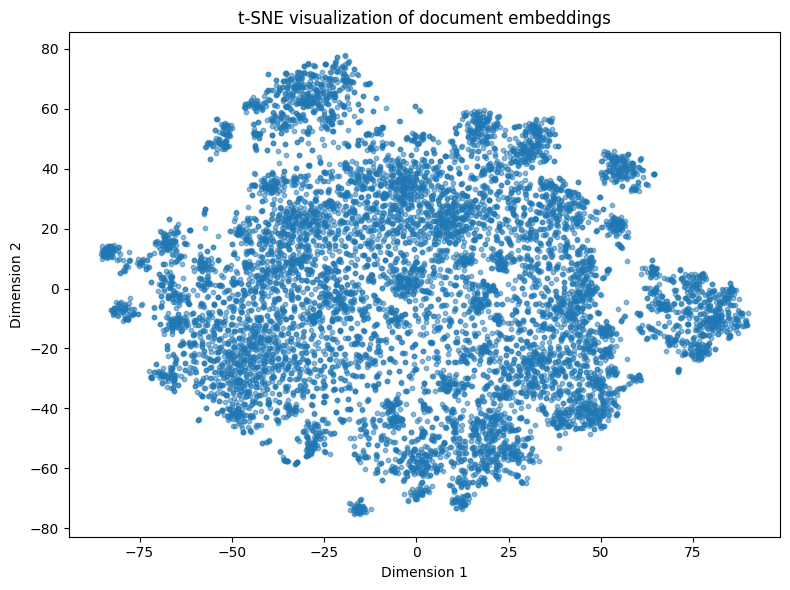

In [116]:
# Plot the embeddings
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.5, s=10)
plt.title('t-SNE visualization of document embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.tight_layout()
plt.show()